In [412]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();

  Activating project at `~/Documents/eth_courses/notebooks/dynamics/julia/basics`


In [413]:
using ModelingToolkit
using OrdinaryDiffEq, DiffEqCallbacks
using ReferenceFrameRotations, LinearAlgebra
using StaticArrays
using Rotations

using GLMakie
using BenchmarkTools
GLMakie.activate!(inline=true)

Quaternion = ReferenceFrameRotations.Quaternion

ReferenceFrameRotations.Quaternion

In [466]:
function plot_position_attitude(sol::ODESolution)
    fig = Figure(resolution = (1000, 700))
    
    ax1 = Axis(fig[1, 1], title="Position")
    ax2 = Axis(fig[1, 2], title="Velocity")
    ax3 = Axis(fig[2, 1], title="Attitude (quaternion)")
    ax4 = Axis(fig[2, 2], title="Angular velocity")

    lines!(ax1, sol.t, sol[r[1]])
    lines!(ax1, sol.t, sol[r[2]])
    lines!(ax1, sol.t, sol[r[3]])

    lines!(ax2, sol.t, sol[ṙ[1]])
    lines!(ax2, sol.t, sol[ṙ[2]])
    lines!(ax2, sol.t, sol[ṙ[3]])
    
    lines!(ax3, sol.t, sol[q[1]])
    lines!(ax3, sol.t, sol[q[2]])
    lines!(ax3, sol.t, sol[q[3]])
    lines!(ax3, sol.t, sol[q[4]])

    lines!(ax4, sol.t, sol[ω[1]])
    lines!(ax4, sol.t, sol[ω[2]])
    lines!(ax4, sol.t, sol[ω[3]])
    
    display(fig)
end

plot_position_attitude (generic function with 1 method)

## Full attitude dynamics 

In [407]:
function quaternion_integrator(q0, ω, dt)
    q_exp = exp( QuatRotation(0, ω[1]*dt/2, ω[2]*dt/2, ω[3]*dt/2, false).q);
    q_exp_q = QuatRotation(q_exp.s, q_exp.v1, q_exp.v2, q_exp.v3, false)
    
    q1 = q_exp_q * q0;

    return q1
end

quaternion_integrator (generic function with 1 method)

In [441]:
function digital_controller(int)

    r =  @view int.u[1:3]
    ṙ =  @view int.u[4:6]
    
    q0_vec = @view int.u[7:10]
    ω = @view int.u[11:13]

    q0 = QuatRotation(q0_vec, false);
    
    dt = 0.01
    
    q1 = quaternion_integrator(q0, ω, dt)

    # set attitude
    int.u[7:10] = [q1.q.s, q1.q.v1, q1.q.v2, q1.q.v3]

end 

control_callback = PeriodicCallback(digital_controller, 0.01, initial_affect=true);

# translation
@variables t (r(t))[1:3]=0 (ṙ(t))[1:3]=0 

# rotation
@variables (q(t))[1:4]=0 (ω(t))[1:3]=0 

# external force, torque
@variables (f(t))[1:3]=0 (τ(t))[1:3] 

@parameters m=1.0 I_xx=0.003 I_yy=0.003 I_zz=0.01

D = Differential(t)

translational_kinematics = D.(r) .~ ṙ

translational_dynamics = D.(ṙ) .~ f / m

rotation_kinematics = D.(q) .~ 0  # implemented in callback

rotation_dynamics = [
    D.(ω[1]) .~ (τ[1] - (I_yy-I_zz )*ω[2]*ω[3]) / I_xx ,
    D.(ω[2]) .~ (τ[2] - (I_xx-I_zz )*ω[1]*ω[3]) / I_yy ,
    D.(ω[3]) .~ (τ[3] - (I_yy-I_xx )*ω[1]*ω[2]) / I_zz ,
    ]

external_force = D.(f) .~ 0 

external_torque = D.(τ) .~ 0 

eqns = vcat(translational_kinematics,translational_dynamics, rotation_kinematics, rotation_dynamics, external_force ,external_torque)

@named model = ODESystem(eqns, t)

sys = structural_simplify(model);

  0.034944 seconds (18.06 k allocations: 3.577 MiB)


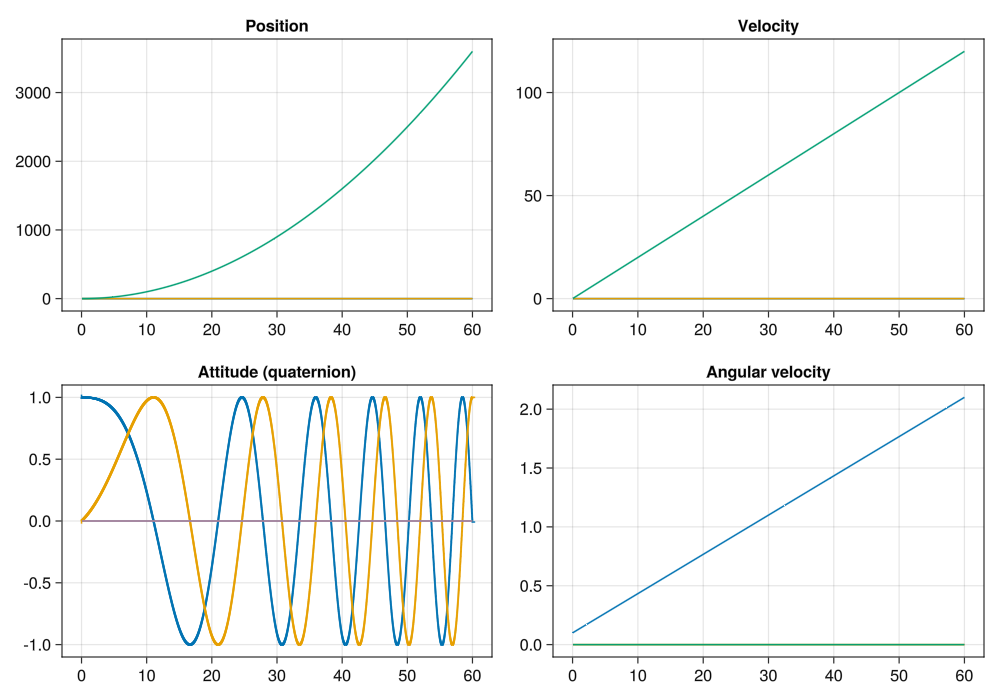

GLMakie.Screen(...)

In [467]:
# sim
tspan = (0.0, 60.0)

control_callback = PeriodicCallback(digital_controller, 0.01, initial_affect=true);

# initial conditions
r₀ = [0.,0.,0.]
ṙ₀ = [0.,0.,0.]
q₀ = [1., 0.,0.,0.]
ω₀ = [0.1,0.,0.]

f₀ = [0.,0.,2.]
τ₀ = [0.0001,0.,0.]

X₀ = vcat(r₀, ṙ₀, q₀, ω₀, f₀, τ₀)

params_ = [sys.I_xx => 0.003, sys.I_yy => 0.003, sys.I_zz => 0.01]

prob = ODEProblem(sys, X₀, tspan,params_, callback=control_callback) 
@time sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8 , save_everystep = false);

plot_position_attitude(sol)